<h3> SciPython/Practical_classes_4

In [15]:
import numpy as np
import matplotlib.pyplot as plt

I implemented the exercises from the last classes.

In [ ]:
#Class dedicated to two variables linear models

class LinearModel2v:
    def __init__(self, alpha = 0.001, diff = 0.001, w1 = 1, w2 = 1, w0 = 1, maxiter = 10000):
        self.alpha = alpha
        self.diff = diff
        self.w1 = w1
        self.w2 = w2
        self.w0 = w0
        self.maxiter = maxiter
        
    def loss_function(self, X, t):
        N = len(X)
        C = 0
        for i in range(N):
            C += (X[i][0]*self.w1+X[i][1]*self.w2+self.w0-t[i])**2
        return C/(2*N)
    
    def update_weights(self, X, t):
        N = len(X)
        dC1 = 0
        dC2 = 0
        dC0 = 0
        for i in range(N):
            y_pred = X[i][0]*self.w1+X[i][1]*self.w2+self.w0
            dC1 += 2*X[i][0]*(y_pred-t[i])
            dC2 += 2*X[i][1]*(y_pred-t[i])
            dC0 += 2*(y_pred-t[i])

        self.w1 = self.w1 - self.alpha*dC1/(2*N)
        self.w2 = self.w2 - self.alpha*dC2/(2*N)
        self.w0 = self.w0 - self.alpha*dC0/(2*N)

    def train(self, X, t):
        l = []
        ile = 0
        while True:
            l.append(self.loss_function(X, t))
            self.update_weights(X, t)
            ile += 1
            if len(l)>2:
                if abs(l[-1]-l[-2])/l[-1] <  self.diff or ile > self.maxiter:
                    break

Let's see how it works on an example

In [ ]:
X = np.array([[1,4],[5,6],[2,2],[6,7],[9,-4],[-2,-3],[-5,1]])
y = np.dot(X, [3, -4])+5  #y=3x1-4x2+5

In [ ]:
model = LinearModel2v()
model.train(X, y)

In [ ]:
model.w1, model.w2, model.w0, model.loss_function(X, y)

(3.000309260729557,
 -3.999675320045806,
 4.99577829150021,
 6.215829033587025e-06)

<h3> Polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

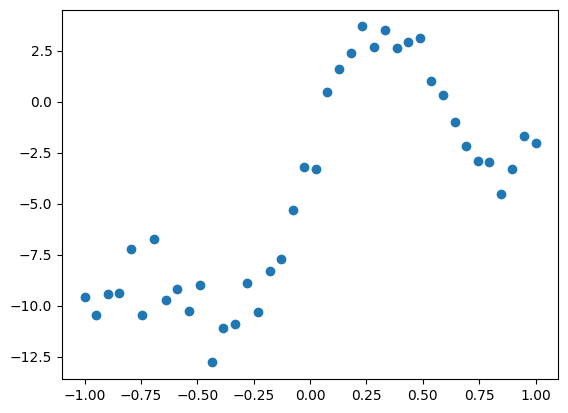

In [ ]:
rng = np.random.RandomState(1)
x = np.linspace(-1, 1, 40)
y = 3*x**3 - 4*x**2 + 6*x - 3 + 5*np.sin(5*x) + rng.randn(40)

plt.scatter(x,y)
plt.show()

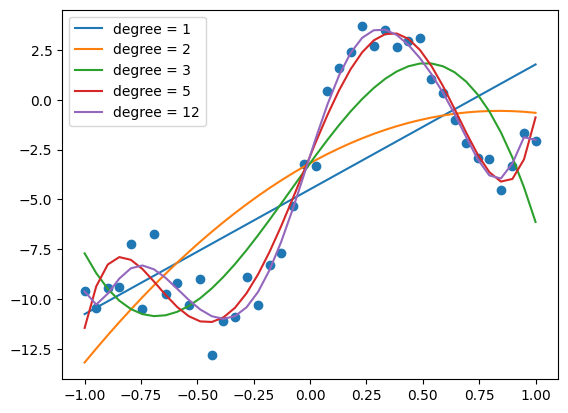

In [ ]:
plt.scatter(x,y)

for d in [1, 2, 3, 5, 12]:
    y_pred = PolynomialRegression(d).fit(x[:, np.newaxis], y).predict(x[:, np.newaxis])
    plt.plot(x, y_pred, label = f"degree = {d}")
    
plt.legend(loc = "best")
plt.show()

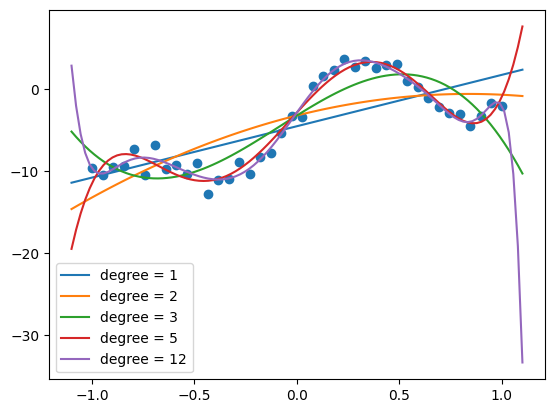

In [ ]:
#how does it generlize?
plt.scatter(x,y)

for d in [1, 2, 3, 5, 12]:
    y_pred = PolynomialRegression(d).fit(x[:, np.newaxis], y).predict(np.linspace(-1.1,1.1,100)[:, np.newaxis])
    plt.plot(np.linspace(-1.1,1.1,100), y_pred, label = f"degree = {d}")
    
plt.legend(loc = "best")
plt.show()

Polynomial with high degrees generalize worse.

<h3> Regularization

The introduction of a wider class of base functions as well as the number of parameters can very quickly lead to overfitting. How to deal with this? For example, by introducing some additional constraints into the cost function depending on the coefficients:


- L2 Regularization (Ridge Regression): $R = \beta \sum_i w_{i}^{2}$ 

- L1 Regularization  (Lasso Regression): $R = \beta \sum_i |w_{i}|$

i.e. $LF = \frac{1}{2N}\sum_{i}(y^{i}-t^{i})^2 + R$.


$w_{new} = w_{old} - \alpha \cdot \frac{d LF}{dw}$

<h4> Exercise1: Define a class that implements linear regression with L1/L2 regularization (regularization type is a parameter: L1, L2 or None) for any number of variables using Gradient Descent or in-built method for minimization.

In [ ]:
# exercise 1
# class dedicated to more variables linear models

class LinearModel:
    def __init__(self, weights, alpha = 0.001, diff = 0.001, reg = None, beta = 1, maxiter = 10000):
        self.alpha = alpha
        self.beta = beta
        self.diff = diff
        self.weights = weights
        self.nweights = len(self.weights)
        self.reg = reg
        self.maxiter = maxiter
        
    def loss_function(self, X, t):
        N = len(X)
        C = 0

        # walk through X
        for i in range(N):
            c = 0
            # walk through the weights
            for w in range(self.nweights):
                # sum weight*feature
                if w == self.nweights - 1:
                    # assuming w0 is always the last one of the list
                    c += self.weights[w]
                else:
                    # other weights
                    c += (X[i][w]*self.weights[w])

            C += (c-t[i])**2


        # regularization
        C = C/(2*N) + self.regularization()

        return C
    
    def update_weights(self, X, t):
        N = len(X)
        dC1 = 0
        dC2 = 0
        dC0 = 0

        dC = [0]*self.nweights

        y_pred = 0

        # walk through X
        for i in range(N):
            # walk through weights
            for w in range(self.nweights):
                # calculate y_pred and dC
                if w == self.nweights -1:                    
                    # assuming w0 is always the last one of the list
                    y_pred += self.weights[w]
                    dC[w] += 2*(y_pred-t[i])
                else:
                    # other weights
                    y_pred += X[i][w]*self.weights[w]
                    dC[w] += 2*X[i][w]*(y_pred-t[i])        

        # derivative of R
        R = 0
        if self.reg == 'l2':
            sum = 0
            for w in self.weights:
                if w < 0:
                    sum += -1
                elif w > 0:
                    sum += 1    
                else:
                    print('weight == 0???')            
            R = self.beta*sum
        elif self.reg == 'l1':
            sum = 0
            for w in self.weights:
                sum += 2*w                
            R = self.beta*sum             

        # new_weight = old_weight - alpha*dLF/2N
        for w in range(self.nweights):
            dC[w] = dC[w] + R
            self.weights[w] -= self.alpha*dC[w]/(2*N)
    

    def train(self, X, t):
        l = []
        ile = 0
        while True:
            l.append(self.loss_function(X, t))
            self.update_weights(X, t)
            ile += 1
            if len(l)>2:
                if abs(l[-1]-l[-2])/l[-1] <  self.diff or ile > self.maxiter:
                    break

    def regularization(self):
        sum = 0
        for w in self.weights:
            if self.reg == 'l1':
                sum += w**2
            elif self.reg == 'l2':
                sum += abs(w)
            else:
                return 0

        return sum*self.beta

  

<h4>Exercise2: Choose any dataset or generate synthetic data. Apply a linear regression model with $L1$ regularization. Divide it into training, test and validation sets (8:1:1). Based on the validation set, select the optimal $\beta$ parameter (consider at least 3-5 different values).


In [ ]:
# exercise 2

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X, y = make_classification(n_samples=1000, n_features=6, n_informative=5, n_redundant=1, n_classes=3, random_state=1) #generate artificial data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

(1000, 6) (1000,)


In [ ]:
betas = [0.001, 0.01, 0.1, 1, 10, 100]

for b in betas:
    weights = [1,1,1,1,1,1,1]
    model = LinearModel(weights = weights, reg = 'l1', beta = b)
    model.train(X_valid, y_valid)
    
    print(model.loss_function(X_valid, y_valid))

# the best beta would be the one with less loss, so 0.01

7.996980535423455
1.1647086213666982
1.1942355654044716
1.481736237828245
3.7726906041406405
9.061008144588287


<h3> Logistic regression

Here, we consider a variable $Y$ which takes only two values - 0 and 1, for example. We want to make predictions about $Y$ based on features $X_1,..,X_n$


We model $p = P(Y=1)$, then $1-p = P(Y=0)$

$p = \frac{1}{1+e^{-(X_1w_1+X_2w_2+...+X_nw_n+w_0)}}$

$BCE = -\frac{1}{N}\sum_i (y_i \log(p(X_{1}^{i},..,X_{n}^{i}))+(1-y_i) \log(1-p(X_{1}^{i},..,X_{n}^{i})))$.

$w_{new} = w_{old} - \alpha \cdot \frac{d BCE}{d w}$.

In [ ]:
from sklearn import linear_model

model = linear_model.LogisticRegression()

X = np.array([[1,2],[2,3],[4,5],[1,-4],[5,-7],[-3,-1]])
y  = np.array([0, 0, 0, 1, 1, 1])

model.fit(X,y);

In [ ]:
model.coef_, model.intercept_ #model parameters

(array([[-0.39682866, -0.82497163]]), array([0.11932619]))

In [ ]:
model.predict([[3,3]]), model.predict_proba([[3,3]]) #class prediction and corresponding probabilities

(array([0]), array([[0.97197068, 0.02802932]]))

<h4> Exercise3:  wustify and recalculate the above probability values ​​based on the parameters of the model.

In [ ]:
# exercise 3

from math import e
p_1 = 1/(1+e**(-(3*-0.39682866+3*-0.82497163+0.11932619)))
p_0 = 1 - p_1

print(p_1, p_0)

0.028029316028845445 0.9719706839711546


<h4> Exercise4: Consider iris dataset with groups 0 and 1 (without 2). Build a logistic model for predicting a category based on 4 features. Firstly, divide a dataset into training and test sets (7:3). Learn model parameters based on the training set and then evaluate the model on test set.

$BCE = -\frac{1}{N}\sum_i (y_i \log(p(X_{1}^{i},..,X_{n}^{i}))+(1-y_i) \log(1-p(X_{1}^{i},..,X_{n}^{i})))$.

$w_{new} = w_{old} - \alpha \cdot \frac{d BCE}{d w}$.

In [ ]:
# exercise 4

from math import e, log

# I got a bit confused with the shapes 
def bce_derivative(w, X, y):
    dbce_dw = np.zeros((5, 1))  

    for i in range(len(X)):
        x = X[i].reshape(-1, 1)
        p = 1 / (1 + np.exp(-(np.dot(X[i], w[:-1]) + w[-1]))).squeeze()
        dbce_dw[:-1] += (p-y[i])*x
        dbce_dw[-1] += p-y[i]

    dbce_dw /= len(X)  
    dbce_dw *= -1

    return dbce_dw

def prob(w, X, i):

    p_1 = 1/(1+e**(-((X[i][0]*-w[0])+(X[i][1]*-w[1])+(X[i][2]*-w[2])+(X[i][3]*-w[3])+w[4])))
    p_0 = 1 - p_1

    return p_1, p_0

def bce(weights, X, y):

    N = len(X)

    sum = 0
    for i in range(N):
        p_1 = prob(weights, X, i)
        p_0 = 1 - p_1
        sum += y[i]*log(p_1)+(1-y[i])*log(p_0)

    total = -1/N*sum

def logistic_regression(weights, X, y, alpha):

    it = 10000
    for i in range(it):
        derivatives = bce_derivative(weights, X, y)

        for j in range(len(weights)):
            weights[j] = weights[j] - alpha*derivatives[j]

    return weights


In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:100]
y = iris.target[:100]

#splitting the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
weights = np.array([1, 1, 1, 1, 1]).reshape(-1, 1)
alpha = 0.01

weights = logistic_regression(weights, X_train, y, alpha)

In [ ]:
y_pred = []

for i in range(len(X_test)):
    probs = prob(weights, X_test, i)
    print(probs)
    y_pred.append(np.argmax(probs))

(array([5.57390059e-07]), array([0.99999944]))
(array([5.55948233e-06]), array([0.99999444]))
(array([4.12924771e-07]), array([0.99999959]))
(array([0.00020343]), array([0.99979657]))
(array([3.71689371e-05]), array([0.99996283]))
(array([0.00010103]), array([0.99989897]))
(array([0.00022482]), array([0.99977518]))
(array([7.5045016e-06]), array([0.9999925]))
(array([5.54485247e-05]), array([0.99994455]))
(array([0.00010103]), array([0.99989897]))
(array([2.75356911e-05]), array([0.99997246]))
(array([0.00016656]), array([0.99983344]))
(array([1.01563044e-06]), array([0.99999898]))
(array([3.3631964e-05]), array([0.99996637]))
(array([3.05111625e-06]), array([0.99999695]))
(array([0.00010103]), array([0.99989897]))
(array([3.73629798e-07]), array([0.99999963]))
(array([2.05052416e-07]), array([0.99999979]))
(array([0.00024846]), array([0.99975154]))
(array([6.12797396e-05]), array([0.99993872]))
(array([1.67449041e-06]), array([0.99999833]))
(array([2.2603243e-06]), array([0.99999774])

In [ ]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.43333333333333335


<h4> Exercise5: Implement a class for logistic regression (from scratch) using Gradient Descent or in-built method for minimization. 

In [23]:
# exercise 5
# class dedicated to logistic regression model

class LogisticModel:
    def __init__(self, weights, alpha = 0.001, maxiter = 10000):
        self.alpha = alpha
        self.weights = weights
        self.nweights = len(self.weights)
        self.maxiter = maxiter
        

    def prob(self, X, i):

        p_1 = 1/(1+e**(-((X[i][0]*-self.weights[0])+(X[i][1]*-self.weights[1])+(X[i][2]*-self.weights[2])+(X[i][3]*-self.weights[3])+self.weights[4])))
        p_0 = 1 - p_1

        return p_1, p_0

    def bce_derivative(self, X, y):
        dbce_dw = np.zeros((5, 1))  

        for i in range(len(X)):
            x = X[i].reshape(-1, 1)
            p = 1 / (1 + np.exp(-(np.dot(X[i], self.weights[:-1]) + self.weights[-1]))).squeeze()
            dbce_dw[:-1] += (p - y[i]) * x
            dbce_dw[-1] += p - y[i]

        dbce_dw /= len(X)  
        dbce_dw *= -1

        return dbce_dw        

    def update_weights(self, X, y):
        
        derivatives = self.bce_derivative(X, y)
        for j in range(self.nweights):
            self.weights[j] = self.weights[j] - self.alpha*derivatives[j]

    def train(self, X, y):
        it = 10000
        for i in range(self.maxiter):
            self.update_weights(X, y)

    def test(self, X_test):
        y_pred = []

        for i in range(len(X_test)):
            probs = self.prob(X_test, i)
        
            y_pred.append(np.argmax(probs))

        return y_pred


In [24]:
log_model = LogisticModel([1,1,1,1,1])

log_model.train(X_train, y_train)

In [25]:
y_pred = log_model.test(X_test)

In [27]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.43333333333333335


<h3> Logistic regression for more than two classes

In this case, we compute the probability for each category $P(Y=i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$ where $i=1,2,...,N$.

In [56]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1) #generate artificial data

print(X.shape, y.shape)

(1000, 10) (1000,)


In [57]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y);

In [58]:
print(model.coef_, model.intercept_) #model parameters

[[ 0.01577681 -0.05318977  0.21160694  0.14655186 -0.24476592 -0.00318551
  -0.20914917 -0.26505038 -0.02765106  0.26778537]
 [ 0.20327639  0.0990516  -0.39851296 -0.1045002   0.02344135 -0.06340171
   0.19494493  0.54495946 -0.18417782 -0.2844254 ]
 [-0.2190532  -0.04586183  0.18690602 -0.04205165  0.22132456  0.06658722
   0.01420424 -0.27990908  0.21182888  0.01664003]] [ 0.0294703  -0.26754233  0.23807203]


In [59]:
model.coef_

array([[ 0.01577681, -0.05318977,  0.21160694,  0.14655186, -0.24476592,
        -0.00318551, -0.20914917, -0.26505038, -0.02765106,  0.26778537],
       [ 0.20327639,  0.0990516 , -0.39851296, -0.1045002 ,  0.02344135,
        -0.06340171,  0.19494493,  0.54495946, -0.18417782, -0.2844254 ],
       [-0.2190532 , -0.04586183,  0.18690602, -0.04205165,  0.22132456,
         0.06658722,  0.01420424, -0.27990908,  0.21182888,  0.01664003]])

In [60]:
#new observation
row = [1.89149379, -0.39847585, 1.63856893, 0.01647165, 1.51892395, -3.52651223, 1.80998823, 0.58810926, -0.02542177, -0.52835426]
#predict the category
yhat = model.predict([row])
print(f'Predicted class: {yhat[0]}')

Predicted class: 1


In [61]:
#predict probabilities
yhat = model.predict_proba([row])
print(f'Predicted probabilities: {yhat[0]}')

Predicted probabilities: [0.16470456 0.50297138 0.33232406]


$P(Y=i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$ where $i=1,2,...,N$.

<h4> Exercise6: Justify and recalculate the above probability values ​​based on the parameters of the model.

In [62]:
# exercise 6

def probabilities(X, coefficients, intercepts):

    values = np.dot(X, coefficients.T) + intercepts
    exps = np.exp(values - np.max(values))
    result = exps / np.sum(exps)

    return result

probabilities = probabilities(row, model.coef_, model.intercept_)
print(probabilities)

[0.16470456 0.50297138 0.33232406]


<h4> Exercise7: Consider iris dataset with groups 0, 1 and 2. Build a logistic model for predicting a category based on 4 features. Firstly, divide a dataset into training and test sets (7:3). Learn model parameters based on the training set and then evaluate the model on test set. Which group is the most challenging to classify?

In [53]:
# exercise 7

def multiclass_bce_derivative(w, X, y):
    dbce_dw = np.zeros((X.shape[1], len(np.unique(y))))

    # probabilities
    z = X.dot(w)
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    probs = e_z / np.sum(e_z, axis=1, keepdims=True)

    for i in range(len(X)):
        x = X[i].reshape(-1, 1)
        for j in range(len(np.unique(y))):
            dbce_dw[:, j] += (probs[i, j] - (y[i] == j)) * x.squeeze()

    dbce_dw /= len(X)
    dbce_dw *= -1

    return dbce_dw

def multiclass_logistic_regression(weights, X, y, alpha):

    it = 10000
    for i in range(it):
        derivatives = multiclass_bce_derivative(weights, X, y)

        for j in range(len(weights)-1):
            for k in range(len(weights.T)):
                weights[j][k] = weights[j][k] - alpha*derivatives[j][k]

    return weights

def probabilities(X, w):
    
    values = np.dot(X, w)
    exps = np.exp(values - np.max(values, axis=1, keepdims=True))
    result = exps / np.sum(exps, axis=1, keepdims=True)

    return result

In [54]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

weights = np.zeros((X_train.shape[1], len(np.unique(y_train))))

alpha = 0.01

weights = multiclass_logistic_regression(weights, X_train, y_train, alpha)


In [51]:
y_pred = []

probs = probabilities(X_test, weights)
print(probs)
y_pred.append(np.argmax(probs))

y_pred

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


[0]

I believe there is something wrong because all predictions are of class 1. even in the 2 classes model. I could not find exactly what it is.

Practical Example

In [ ]:
import pandas as pd 

#data and its description: https://archive.ics.uci.edu/ml/datasets/Wine
df_wine = pd.read_csv('wine.data')
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanolds', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanolds,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [ ]:
print('Categories: ', np.unique(df_wine['Class label']))

Categories:  [1 2 3]


In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

#standarization if often peformed before the model buliding if variables are in different ranges
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [ ]:
lr1 = LogisticRegression(penalty='l2', C=0.1) #C = 1/beta  (regularization L2)
lr1.fit(X_train_std, y_train)

print('Accuracy on the training set:', lr1.score(X_train_std, y_train))
print('Accuracy on the test set:', lr1.score(X_test_std, y_test))

Accuracy on the training set: 0.991869918699187
Accuracy on the test set: 1.0


In [ ]:
weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l2', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    
weights = np.array(weights)

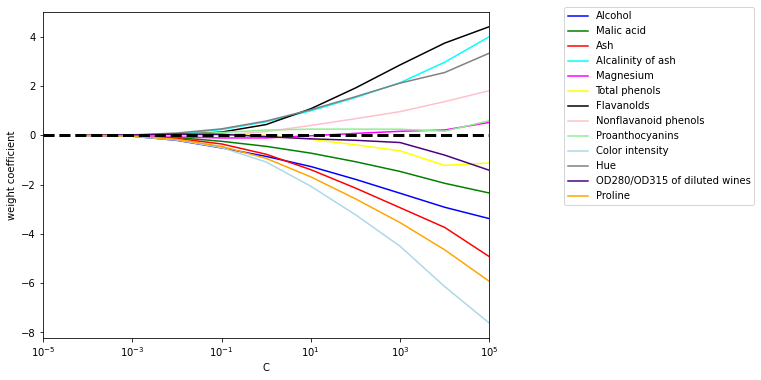

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot( params, 
              weights[:, column], 
              label=df_wine.columns[column+1],
              color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, 
          fancybox=True)
plt.show()

<h4> Exercise8: Explain the above plot? Why for small $C$ values we observe the convergance to 0?


this is a plot of the weight values against C parameter in L2 regularization. this penalizes big weights, encouraging the model to use smaller weights. with smaller C, the strength of the regularization term is higher, so we have smaller weights


<h3> Supplementary materials

Find the minimum falue of $f(w_1,w_2) = (w_1-1)^2+(w_2+3)^2$

In [ ]:
from scipy.optimize import minimize #in-built method for minimization

fun = lambda w: (w[0] - 1)**2 + (w[1] + 3)**2
res = minimize(fun, (2, 0), method='SLSQP')
print(res.x) #where is the minium?

[ 1. -3.]
